# Importing libraries and cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.mixture import GaussianMixture

import hdbscan

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [2]:
# Importing the cleaned dataset from my first notebook
file_path = '../data/data_cleaned.csv'
df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

# Filtering the dataset

Based on the initial analysis conducted in previous notebooks, I have made some preliminary decisions regarding data filtering. These decisions include retaining only sales data from the UK and filtering the dataset to include only sales related to products.

In [3]:
# Filtering out the data that are not for products (shipping, bank fees etc)
df_fltrd = df[df.StockCode != 'OTHER']

# Focusing only on clients from UK (they consist 90% of the clients)
# -> At a later stage I could also check adding Germany and France, to refer then to almost 95% of clients
df_fltrd = df_fltrd[df_fltrd.Country == 'United Kingdom']

# Finally, dropping the null values from CustomerID, since the ML model will be based on the different clients
df_fltrd.dropna(subset='CustomerID', inplace=True)

# Creating new column with the total price for each item 
df_fltrd['TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

# Feature Engineering

**Total Quantity:** Wholesale customers are likely to purchase larger quantities of items compared to retail customers: using the total quantity purchased by each customer as a feature.

**Total Price:** Wholesale customers typically spend more money on their purchases compared to retail customers: using the total price of orders can help distinguish between the two groups.

**Average Quantity per Item:** Average quantity per item for each customer. Wholesale customers may buy multiples of the same item in a single order, leading to a higher average quantity per item.

**Average Order Value:** The average amount spent per order by each customer. 

**Total Orders:** Wholesale customers are likely to place more orders than retail customers. To calculate the total number of orders for each customer over a given time period. *Not sure if I will use that for the final model.*

For my ML model I will try clustering algorithms such as K-means, DBSCAN, HDBSCAN, or hierarchical clustering. I will do feature engineering, and conduct an EDA to see my data, and experiment and decide on the best model.

In [4]:
# Notes

# inertia - for clustering K-means
# Silhouette
# error metrics differerent per model

# IMPORTANT !!!!!
# after doing the two clusters, to defined with supervised ML, the clients with customerID unknown, to see to which cluster they belong
# so that in the inventory forecast to include these data (it is 1/4 of my data)

# for this case i need to think how to handle the fact that the two cluster will have different amount of samples,
# the retail has wayyy more clients
# should i do some techniques to make the amounts more equal? 

In [5]:
# I will do a function for the feature engineering and the consrtucted dataframe, 
# cause I will use it more than once as exploration

def feat_eng(df):
    #Total quantity purchased
    cust = df.groupby('CustomerID')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'TotalQuantity'})

    # Total value of orders
    cust = pd.merge(cust, df.groupby('CustomerID')['TotalPrice'].sum().reset_index().rename(columns={'TotalPrice': 'TotalValue'}), 
                                                                                       how='left', on='CustomerID')

    # Average quantity per item per order
    # Grouping by StockCode, in case in the same invoice client has added the product more than once
    item_quant = df.groupby(['CustomerID','InvoiceNo','StockCode'])['Quantity'].sum().reset_index()

    cust = pd.merge(cust, item_quant.groupby('CustomerID')['Quantity'].mean().round(2).reset_index().rename(columns={'Quantity':'AvrgQuantity'}), 
                                                                                       how='left', on='CustomerID')

    # Average value per order
    order_val = df.groupby(['CustomerID','InvoiceNo'])['TotalPrice'].sum().reset_index()
    avrg_val = order_val.groupby('CustomerID')['TotalPrice'].mean().round(2).reset_index().rename(columns={'TotalPrice':'AvrgOrderValue'})

    cust = pd.merge(cust, avrg_val, how='left', on='CustomerID')

    # Total orders number
    cust = pd.merge(cust, df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'TotalOrders'}), 
                                                                                       how='left', on='CustomerID')

    # Setting CustomerID as index
    cust.set_index('CustomerID', inplace=True)

    return cust

In [6]:
cust = feat_eng(df_fltrd)
cust.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,TotalOrders
CustomerID,,,,,
12346,74215,92768.75,74215.00,92768.75,1
12747,1275,4722.51,12.38,429.32,11
12748,25051,46021.25,5.87,223.40,206
12749,1470,4043.94,7.42,808.79,5
12820,722,938.94,12.24,234.74,4


# EDA

Based on the following analyis I see that I have many outliers and noise in my data. These are the conclusions drawn from this 'EDA' section:

There is an important decision to be made. I see that I have two types of outliers/ noise.
- One comes from the two invoices with number '581483','541431' (two outliers). The Quantity and value of these invoices is huge, not comparable at all with the rest of the 19962 invoices. Also, these 2 invoices, one is from a client that ordered only once (that very big order of only one item) and the other client had this huge order and only two more items at another time. That makes me think that they are not really repeated wholesale customers, and are stand-alone cases that since they differ so much for the model accuracy can be disadvantage.
- Then when I see my data without these two, I can see the noise around my data. This second type of outliers they still need to be treated, but their scale is more comparable to the rest of the data.

I am going to do outlier clipping for the noise at my data, but when I do it without removing the 2 outliers first, the dataset is still very noisy and I don't trust that the trained ML model can be accurate enough.
For that reason I decided in the next section of the notebook 'Outliers' to treat these two types differently.

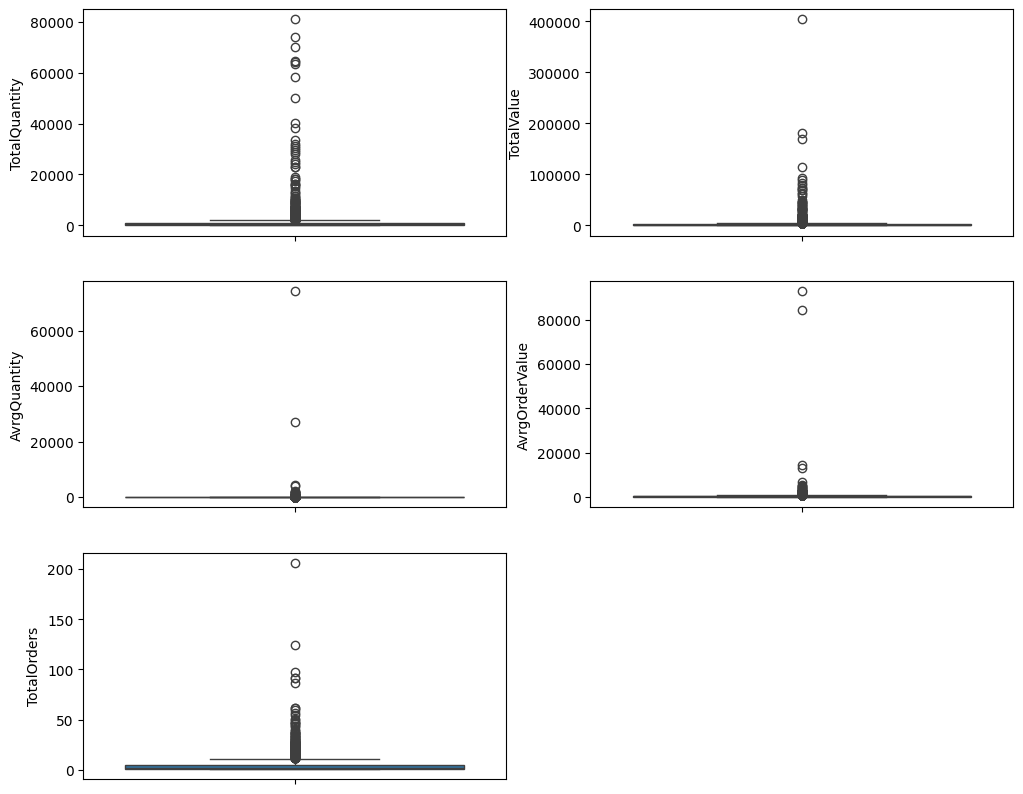

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

sns.boxplot(data=cust['TotalQuantity'], ax=ax[0, 0]) 
sns.boxplot(data=cust['TotalValue'], ax=ax[0, 1]) 
sns.boxplot(data=cust['AvrgQuantity'], ax=ax[1, 0]) 
sns.boxplot(data=cust['AvrgOrderValue'], ax=ax[1, 1]) 
sns.boxplot(data=cust['TotalOrders'], ax=ax[2, 0]) 

# Remove the empty subplot
fig.delaxes(ax[2, 1])

plt.show()

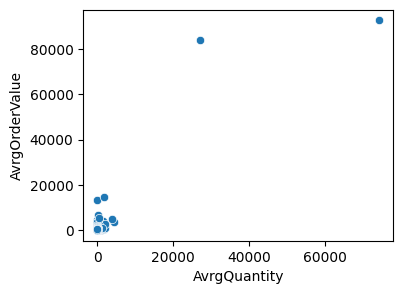

In [8]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust, x='AvrgQuantity', y='AvrgOrderValue')
plt.show()

In [9]:
# Looking into the two big outliers
df[df.InvoiceNo.isin(['581483','541431'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


In [10]:
df[df.CustomerID.isin([12346,16446])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
188029,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446,United Kingdom
188030,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


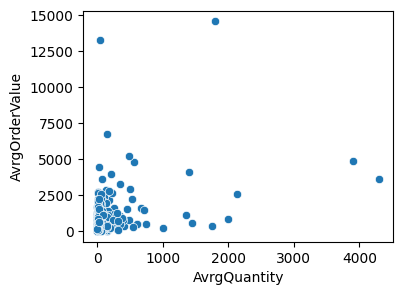

In [11]:
# Checking the scatterplots without the two big outliers, to see my data a bit more clearly
# I am doing he same process as above, using the function I defined
cust_fltrd = feat_eng(df_fltrd[~df_fltrd.InvoiceNo.isin(['581483','541431'])])

# Plotting
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_fltrd, x='AvrgQuantity', y='AvrgOrderValue')
plt.show()

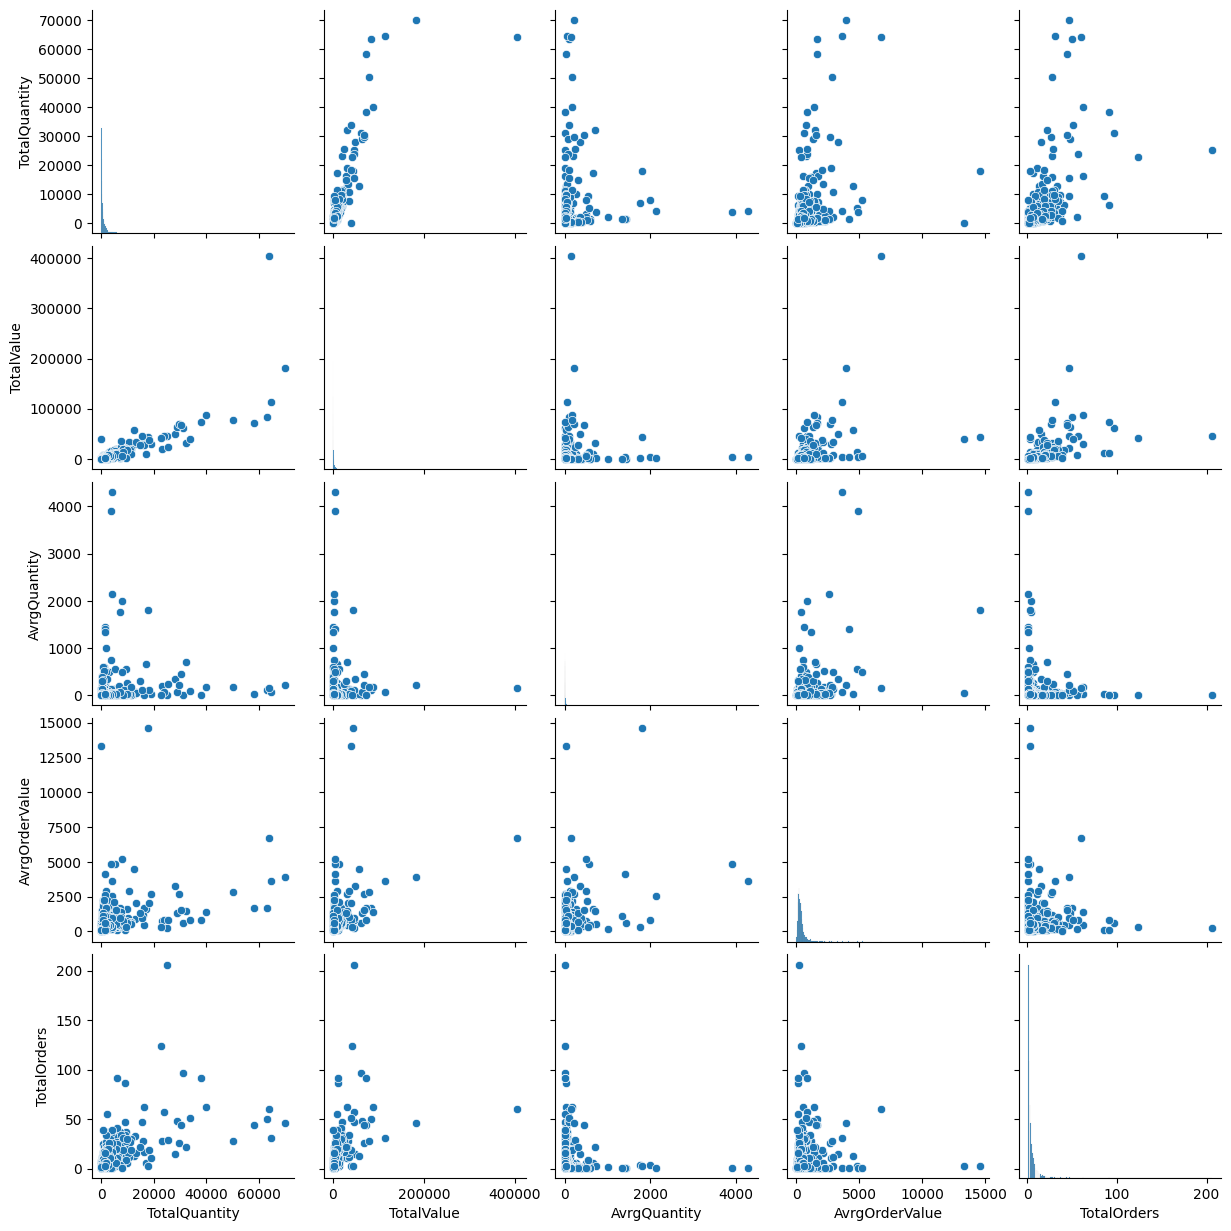

In [12]:
sns.pairplot(cust_fltrd)

# Outliers: data normalization

Based on the noise and outliers that I identified in the previous section, I am going to implement two different approaches for the two types of outliers.
- to the two outliers with the huge difference in scale, I am going to do scaling to a range, scaling them to highest next value (after these two).
- then after completing that, I will do outlier clipping for the rest of the outliers/ noice. I trust that in this way my model will have better scale and will have more accuracy, and at the same time, since I only want two clusters (wholesale and retail) these outliers/noise will still be the highest values in my dataset, and they will most probably be incorporated into the cluster of the wholesale customers. For that I will use the Stardard Deciation method, by z-score to +-3σ (σ is the standard deviation).

Helpful aricle:
https://developers.google.com/machine-learning/data-prep/transform/normalization#:~:text=Z%2Dscore%20is%20a%20variation,extreme%20that%20you%20need%20clipping.

In [13]:
# scaling within a range, updating the Quantity and accordingly the TotalPrice
df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'Quantity'] = df_fltrd.Quantity.sort_values(ascending=False).values[2]
df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

In [14]:
# Creating the updated customer dataframe
cust_norm = feat_eng(df_fltrd)

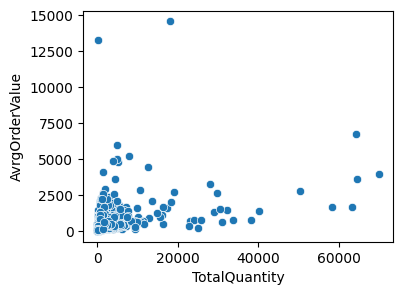

In [15]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_norm, x='TotalQuantity', y='AvrgOrderValue')
plt.show()

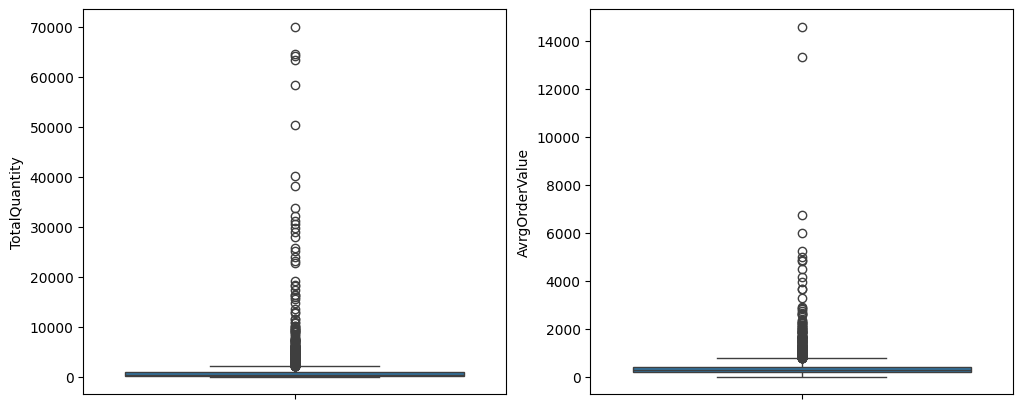

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(data=cust_norm['TotalQuantity'], ax=ax[0]) 
sns.boxplot(data=cust_norm['AvrgOrderValue'], ax=ax[1]) 

plt.show()

In [17]:
cust_norm.columns

Index(['TotalQuantity', 'TotalValue', 'AvrgQuantity', 'AvrgOrderValue',
       'TotalOrders'],
      dtype='object')

In [18]:
cust_norm_clip = cust_norm.copy()

In [19]:
# I will find the Upper limit with the standard deviation method
# I don't have lower limit, cause everything start from 0
tq_UpperLimit = (cust_norm_clip['TotalQuantity'].mean() + cust_norm_clip['TotalQuantity'].std()*3).round(0).astype(int)
tv_UpperLimit = (cust_norm_clip['TotalValue'].mean() + cust_norm_clip['TotalValue'].std()*3).round(2)
av_UpperLimit = (cust_norm_clip['AvrgQuantity'].mean() + cust_norm_clip['AvrgQuantity'].std()*3).round(2)
aov_UpperLimit = (cust_norm_clip['AvrgOrderValue'].mean() + cust_norm_clip['AvrgOrderValue'].std()*3).round(2)
to_UpperLimit = (cust_norm_clip['TotalOrders'].mean() + cust_norm_clip['TotalOrders'].std()*3).round(0).astype(int)

In [20]:
# Chekcing how many outliers there are that fit these requirements
cust_norm_clip[cust_norm_clip['TotalQuantity'] > tq_UpperLimit].shape[0] # 34 instances
cust_norm_clip[cust_norm_clip['TotalValue'] > tv_UpperLimit].shape[0] # 32 instances
cust_norm_clip[cust_norm_clip['AvrgQuantity'] > av_UpperLimit].shape[0] # 23 instances
cust_norm_clip[cust_norm_clip['AvrgOrderValue'] > aov_UpperLimit].shape[0] # 44 instances
cust_norm_clip[cust_norm_clip['TotalOrders'] > to_UpperLimit].shape[0] # 50 instances, more outliers

50

In [21]:
# from domain knowledge I was debating if to do total orders. Given also the outliers, I will not use it
cust_norm_clip.drop('TotalOrders',axis=1,inplace=True)

In [22]:
# Clipping the data
cust_norm_clip.loc[cust_norm_clip['TotalQuantity'] > tq_UpperLimit , 'TotalQuantity'] = tq_UpperLimit
cust_norm_clip.loc[cust_norm_clip['TotalValue'] > tv_UpperLimit , 'TotalValue'] = tv_UpperLimit
cust_norm_clip.loc[cust_norm_clip['AvrgQuantity'] > av_UpperLimit , 'AvrgQuantity'] = av_UpperLimit
cust_norm_clip.loc[cust_norm_clip['AvrgOrderValue'] > aov_UpperLimit , 'AvrgOrderValue'] = aov_UpperLimit

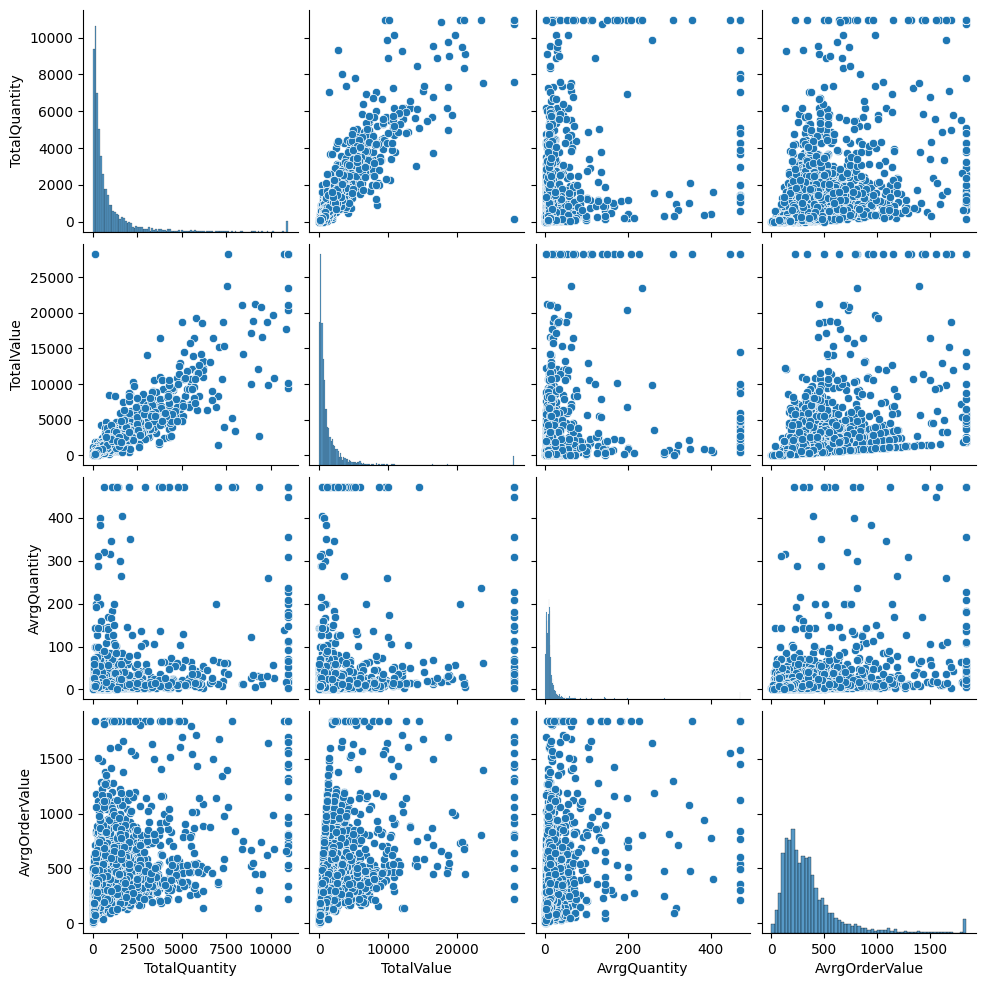

In [23]:
sns.pairplot(cust_norm_clip)

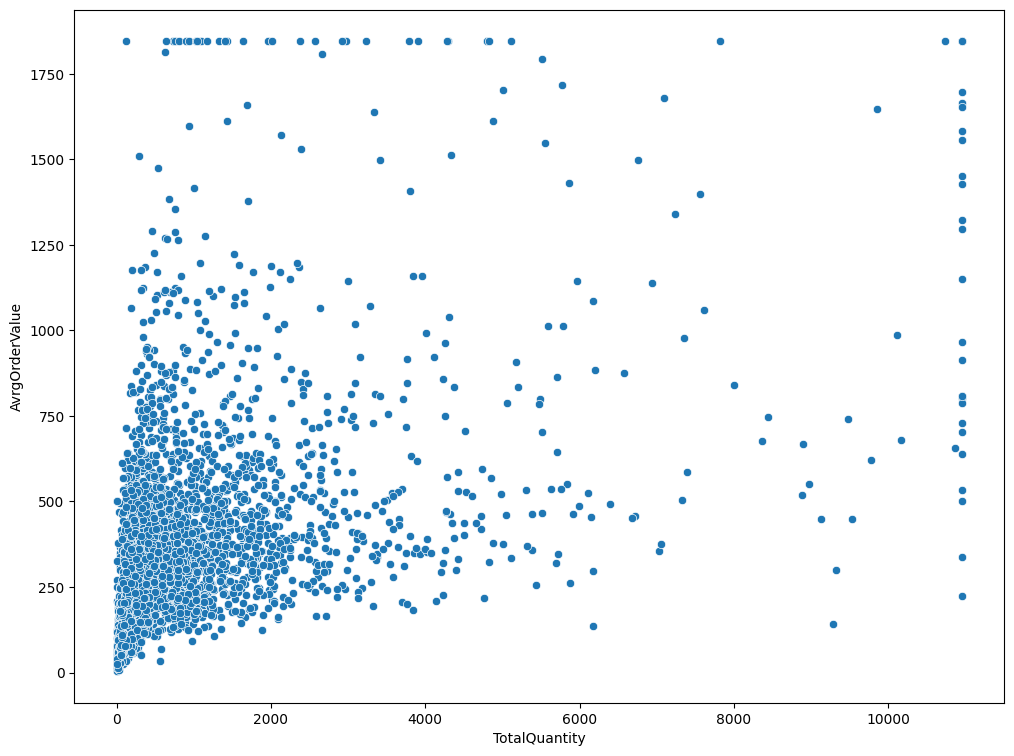

In [24]:
plt.figure(figsize=(12, 9)) 
sns.scatterplot(data=cust_norm_clip, x='TotalQuantity', y='AvrgOrderValue')
plt.show()

# Scaling data

Normalization rescales the data to have values between 0 and 1, while standardization rescales the data to have a mean of 0 and a standard deviation of 1. There are various methods to normalize or standardize the data, such as min-max scaling, z-score scaling, or log transformation. Here I tried the first two, but I will choose the standardization (z-score scaling) that is less sensitive to outliers than min-max scaling (where scale is heavily influenced by the extreme maximum and minimum values).

### Min-Mix Scaler

**Normalization:** in this case, the values are transformed in such a way that the final values will be in the range [0,1].
$$z = \frac{x-min(x)}{(max(x)-min(x))}$$
*In the end I am not using that.*

In [25]:
'''
# Creating an instance of the class MinMaxScaler normalizer
normalizer = MinMaxScaler()

normalizer.fit(cust)

# applying the transformation
cust_norm = normalizer.transform(cust)

cust_norm = pd.DataFrame(cust_norm, columns = cust.columns, index=cust.index)
'''

'\n# Creating an instance of the class MinMaxScaler normalizer\nnormalizer = MinMaxScaler()\n\nnormalizer.fit(cust)\n\n# applying the transformation\ncust_norm = normalizer.transform(cust)\n\ncust_norm = pd.DataFrame(cust_norm, columns = cust.columns, index=cust.index)\n'

### StandardScaler

Standarization: the values are transfomed to end up with mean = 0 and std = 0.

$$z = \frac{(x-mean(x))}{\sigma}$$

In [26]:
# Scaling the data
scaler = StandardScaler()

scaler.fit(cust_norm_clip)

# applying the transformation
cust_norm_clip_stndrd = scaler.transform(cust_norm_clip)

cust_norm_clip_stndrd = pd.DataFrame(cust_norm_clip_stndrd, columns = cust_norm_clip.columns, index=cust_norm_clip.index)
cust_norm_clip_stndrd.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
CustomerID,,,,
12346,2.575901,1.312867,10.005464,5.154360
12747,0.256937,0.927293,-0.132466,0.255785
12748,6.626359,8.035051,-0.276287,-0.456589
12749,0.385220,0.722486,-0.242043,1.568550
12820,-0.106861,-0.214669,-0.135559,-0.417358


# Elbow Method, for the optimal number of clusters

Ideally I want to make 2 clusters, one for wholesale and one for retail customers.
I am doing the Elbow Method (most commonly used with clustering algorithms like K-means) to see how the inertia looks depending on the number of clusters.

From the result I can see that doing 2 or 4 cluster would be a good option.

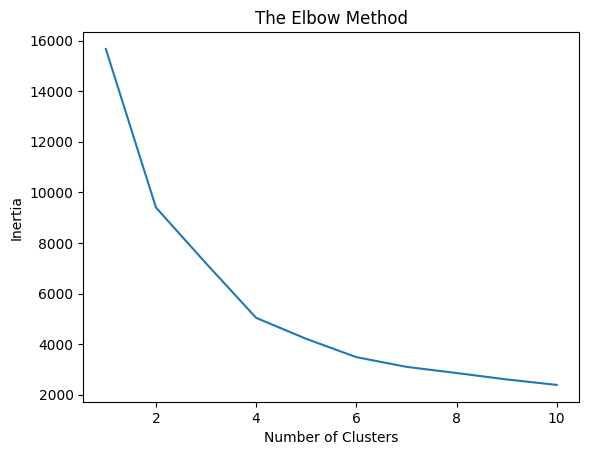

In [27]:
# Finding the optimal number of clusters
inertias = []

# Checking the plot for 1-10 clusters
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cust_norm_clip_stndrd)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# 2 or 4 clusters

# Building models

Helpful resource:
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

## Clustering with K-Means

After looking at my EDA, I conclude that K-Means will not be a good model for my dataset. I will test it however anywyay.

K-means can be quite sensitive to oultiers and has an intrinsic preference for globular clusters.

In [28]:
# Choosing 4 clusters
kmeans = KMeans(n_clusters=4)

# Using only the two more interesting features
kmeans.fit(cust_norm_clip_stndrd)

KMeans(n_clusters=4)

In [29]:
cust_kmeans = cust_norm_clip_stndrd.copy()
cust_kmeans['kmeans_4'] = kmeans.labels_
cust_kmeans

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,kmeans_4
CustomerID,,,,,
12346,2.575901,1.312867,10.005464,5.154360,2
12747,0.256937,0.927293,-0.132466,0.255785,1
12748,6.626359,8.035051,-0.276287,-0.456589,3
12749,0.385220,0.722486,-0.242043,1.568550,1
12820,-0.106861,-0.214669,-0.135559,-0.417358,0
...,...,...,...,...,...
18280,-0.552234,-0.443507,-0.306553,-0.604135,0
18281,-0.546313,-0.473668,-0.235637,-0.949840,0
18282,-0.514078,-0.452001,-0.216416,-0.965442,0


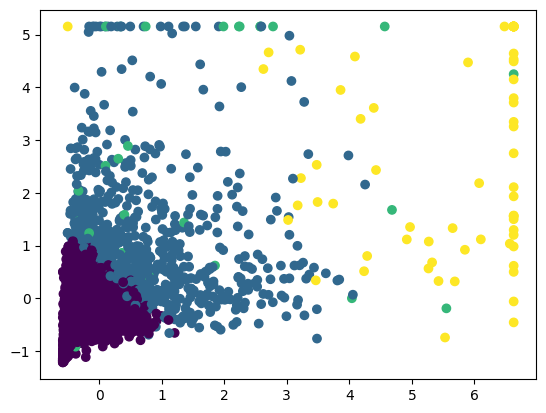

In [30]:
# Plotting the results
plt.scatter(x=cust_kmeans['TotalQuantity'], y=cust_kmeans['AvrgOrderValue'], c=cust_kmeans['kmeans_4'])
plt.show()

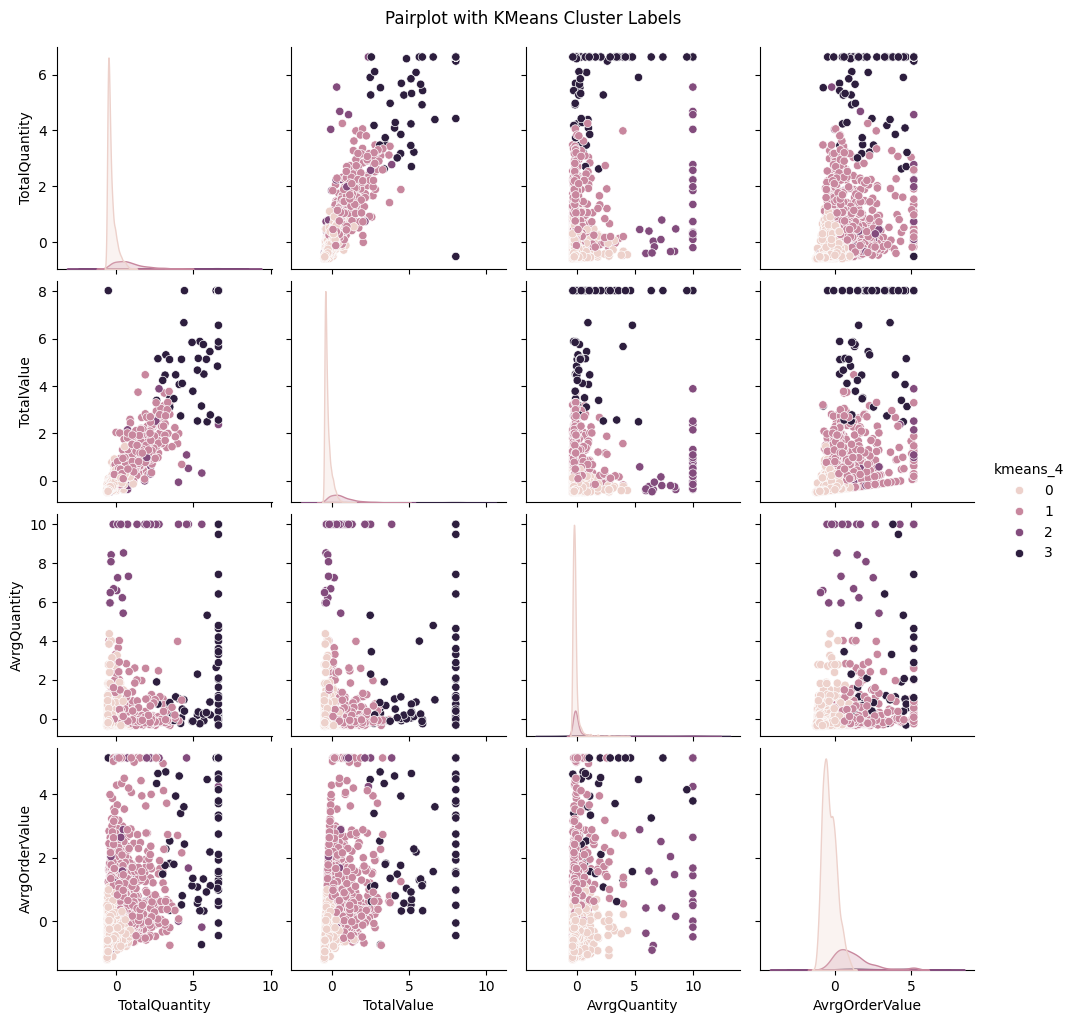

In [31]:
sns.pairplot(cust_kmeans, hue='kmeans_4')
plt.suptitle("Pairplot with KMeans Cluster Labels", y=1.02)
plt.savefig("../images/pairplot_kmeans.png")
plt.show()

## Clustering with DBSCAN

A density-based clustering algorithm.

DBSCAN tends to fall short of identifying clusters with non-uniform density.

In [32]:
dbscan = DBSCAN(eps=0.5, min_samples=10)

labels_dbscan = dbscan.fit_predict(cust_norm_clip_stndrd)

np.unique(labels_dbscan)

cust_dbscan = cust_norm_clip_stndrd.copy()
cust_dbscan['dbscan_labels'] = labels_dbscan

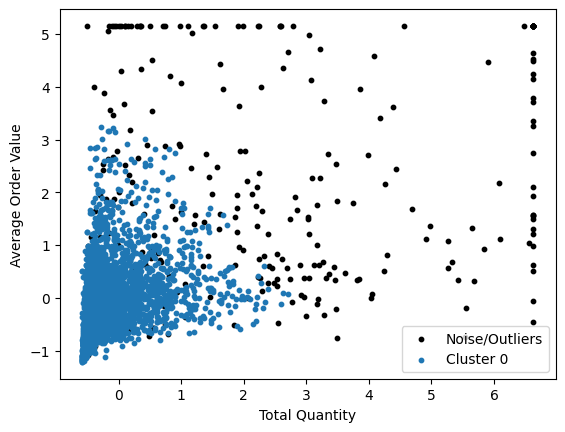

In [33]:
def scatter_plot(df, labels):
    # Define colors for each cluster, now works for until 10 labels
    #cluster_colors = ['blue', 'red', 'green', 'brown', 'pink', 'yellow', 'silver', 'orange', 'purple', 'cyan']
    cluster_colors =sns.color_palette('tab10')

    # Visualising the clusters
    for label in np.unique(labels):
        if label == -1:
            # Plot points labeled as noise/outliers in black
            plt.scatter(df.iloc[labels == label, 0], df.iloc[labels == label, 1], s = 10, color = 'black', label = 'Noise/Outliers')
        else:
            # Plot points for each cluster with different color
            plt.scatter(df.iloc[labels == label, 0], df.iloc[labels == label, 1], s = 10, color = cluster_colors[label], label = f'Cluster {label}')

    plt.xlabel('Total Quantity')
    plt.ylabel('Average Order Value')
    plt.legend()
    plt.show()

    return


scatter_plot(cust_dbscan[['TotalQuantity','AvrgOrderValue']], labels_dbscan)

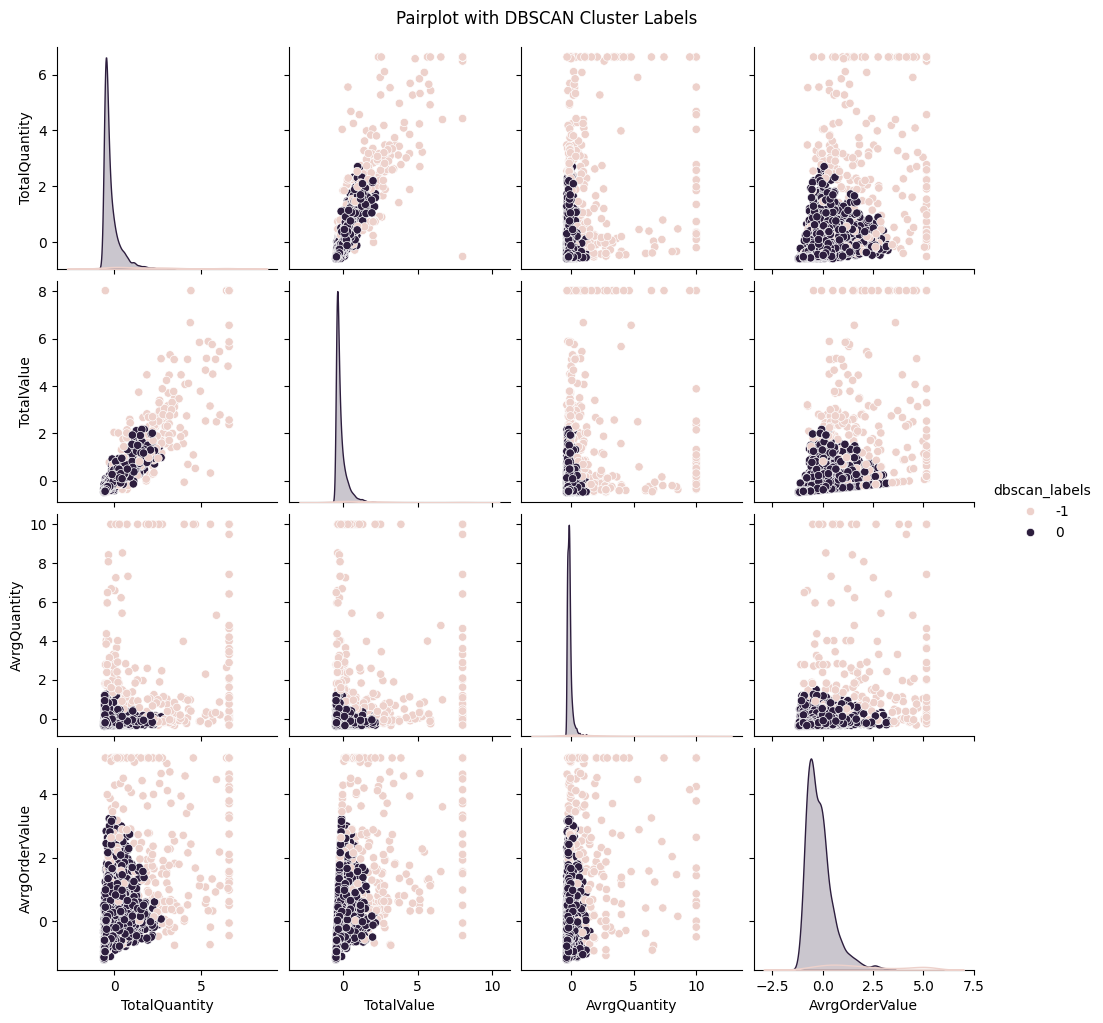

In [34]:
sns.pairplot(cust_dbscan, hue='dbscan_labels')
plt.suptitle("Pairplot with DBSCAN Cluster Labels", y=1.02)
plt.savefig("../images/pairplot_dbscan.png")
plt.show()

## Clustering with HDBSCAN

In [35]:
# hyperparameter

[-1  0  1  2  3]


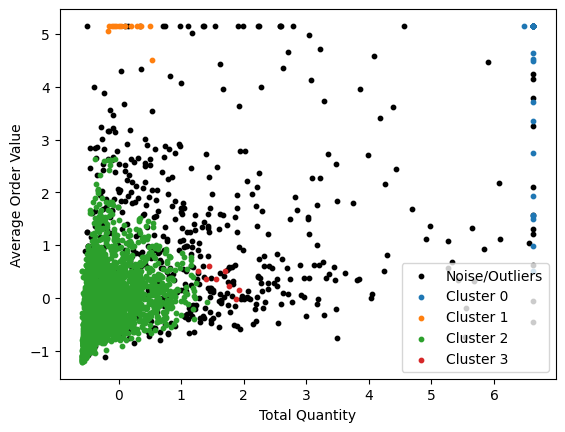

[-1  0  1  2]


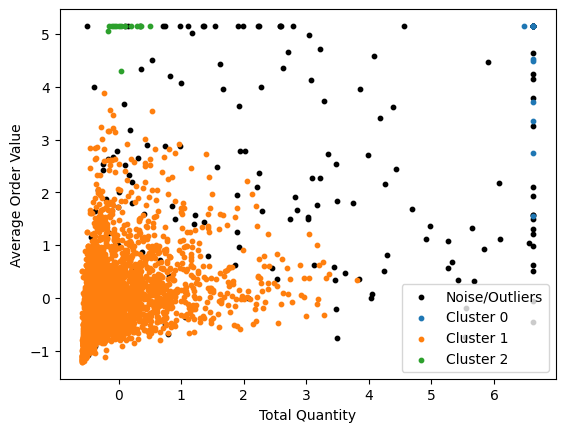

[-1  0  1  2]


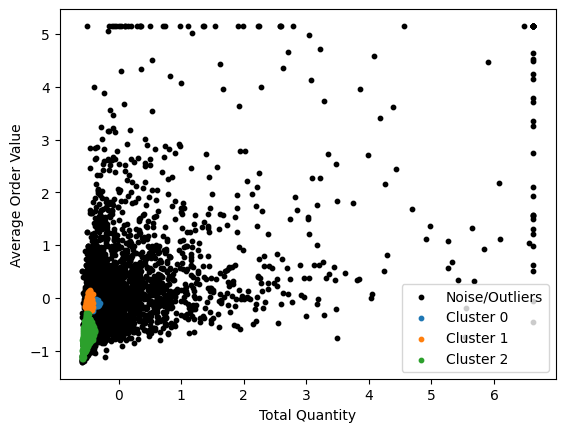

In [36]:
PARAM = ({"min_cluster_size": 8}, {"min_cluster_size": 10}, {"min_cluster_size": 20})
for i, param in enumerate(PARAM):
    hdb = HDBSCAN(**param).fit(cust_norm_clip_stndrd)
    labels = hdb.labels_

    print(np.unique(labels))
    scatter_plot(cust_norm_clip_stndrd[['TotalQuantity','AvrgOrderValue']], labels)

[-1  0  1  2]


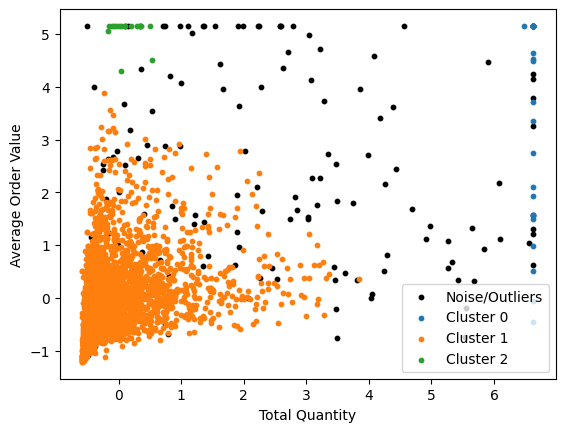

[-1  0  1  2  3]


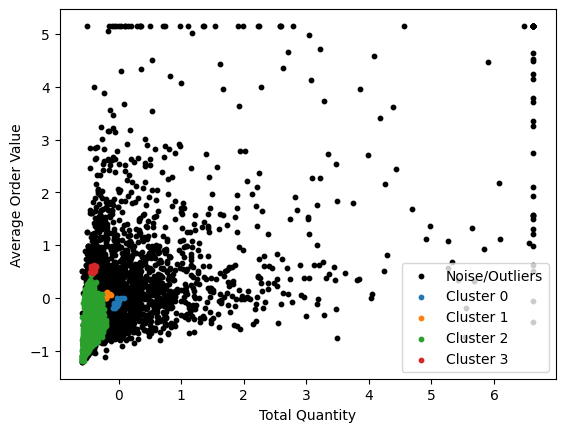

[-1  0  1]


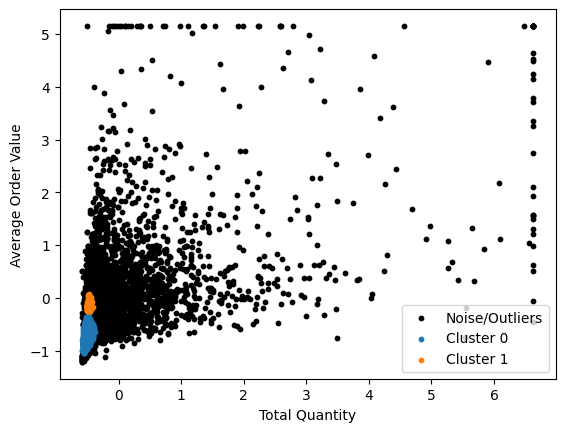

In [37]:
PARAM = (
    {"min_cluster_size": 10, "min_samples": 5},
    {"min_cluster_size": 10, "min_samples": 15},
    {"min_cluster_size": 10, "min_samples": 40},
)

for i, param in enumerate(PARAM):
    hdb = HDBSCAN(**param).fit(cust_norm_clip_stndrd)
    labels = hdb.labels_

    print(np.unique(labels))
    scatter_plot(cust_norm_clip_stndrd[['TotalQuantity','AvrgOrderValue']], labels)

[-1  0  1  2]


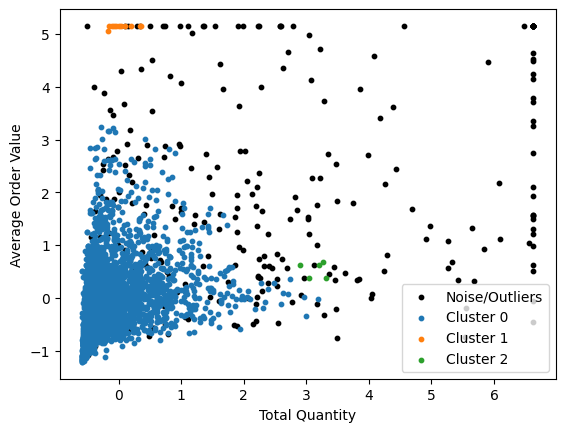

[-1  0]


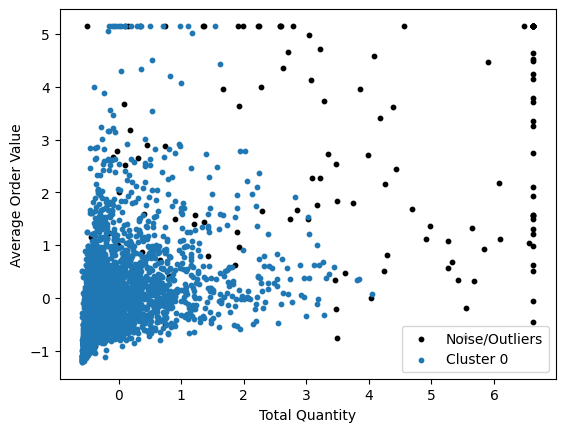

[-1  0  1  2]


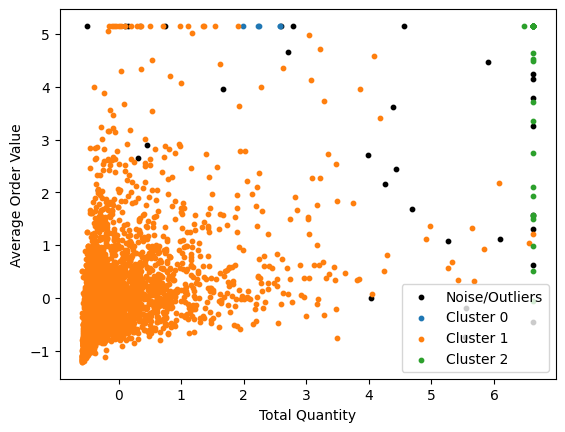

In [38]:
PARAM = (
    {"cut_distance": 0.5},
    {"cut_distance": 1},
    {"cut_distance": 2},
)
hdb = HDBSCAN()
hdb.fit(cust_norm_clip_stndrd)

for i, param in enumerate(PARAM):
    labels = hdb.dbscan_clustering(**param)

    print(np.unique(labels))
    scatter_plot(cust_norm_clip_stndrd[['TotalQuantity','AvrgOrderValue']], labels)

[-1  0  1  2]


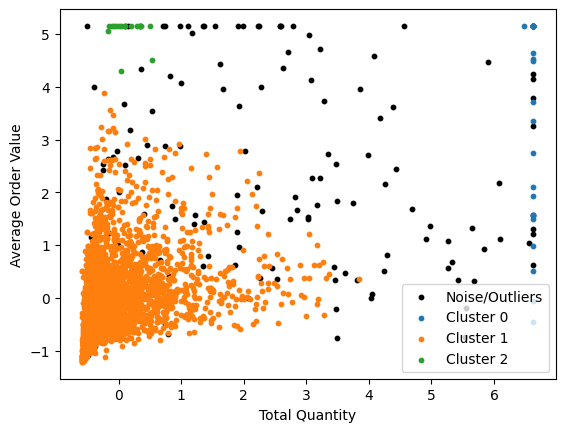

In [39]:
# I choose from the aboves the parameters that look best
hdb = HDBSCAN(min_cluster_size= 10, min_samples= 5).fit(cust_norm_clip_stndrd)
hdb_labels = hdb.labels_

cust_hdbscan = cust_norm_clip_stndrd.copy()
cust_hdbscan['hdbscan_labels'] = hdb_labels

print(np.unique(hdb_labels))
scatter_plot(cust_hdbscan[['TotalQuantity','AvrgOrderValue']], hdb_labels)

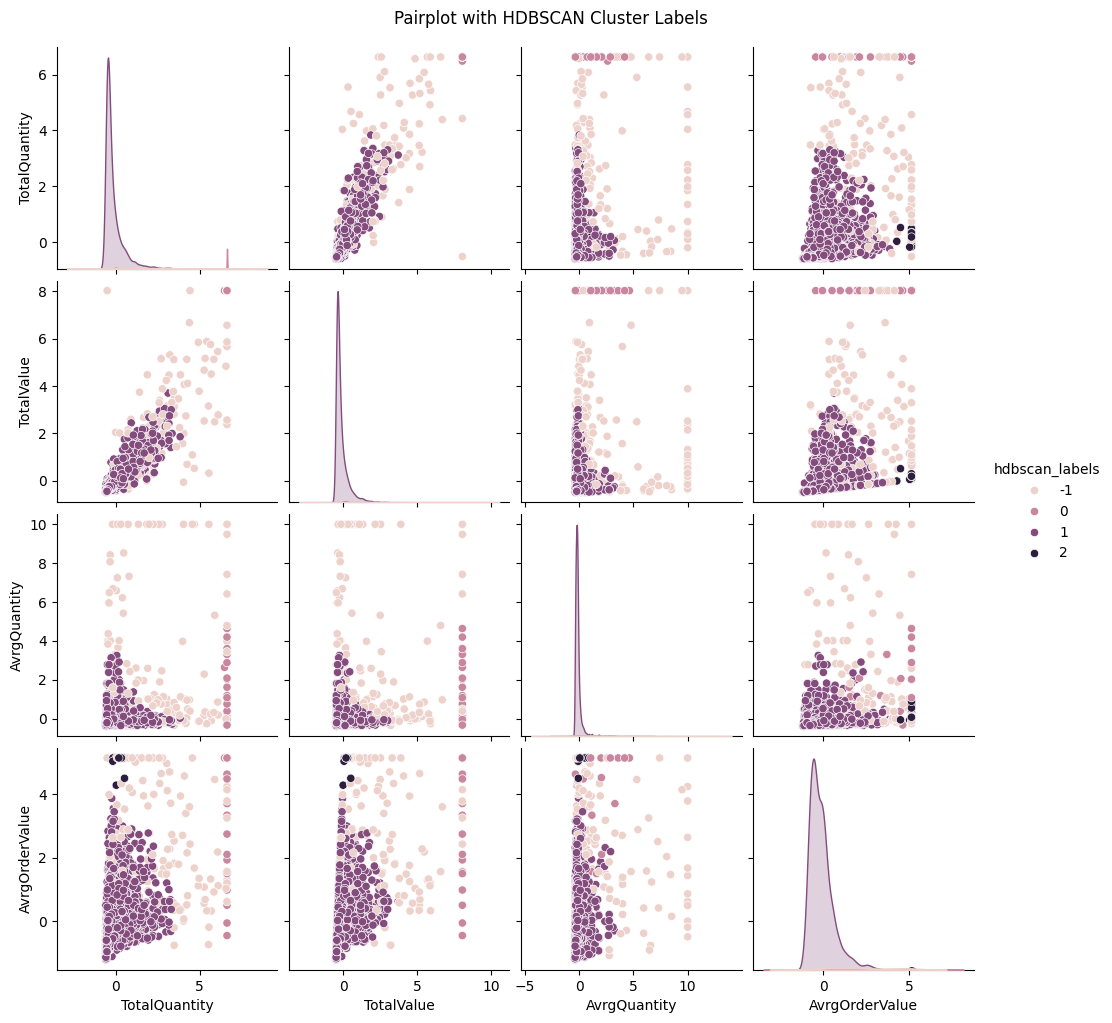

In [40]:
sns.pairplot(cust_hdbscan, hue='hdbscan_labels')
plt.suptitle("Pairplot with HDBSCAN Cluster Labels", y=1.02)
plt.savefig("../images/pairplot_hdbscan.png")
plt.show()

## Gaussian Mixture clustering

In [41]:
gm = GaussianMixture(n_components=4).fit(cust_norm_clip_stndrd)

In [42]:
cust_gm = cust_norm_clip_stndrd.copy()
cust_gm['gm_4'] = gm.predict(cust_norm_clip_stndrd)

cust_gm

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,gm_4
CustomerID,,,,,
12346,2.575901,1.312867,10.005464,5.154360,1
12747,0.256937,0.927293,-0.132466,0.255785,2
12748,6.626359,8.035051,-0.276287,-0.456589,1
12749,0.385220,0.722486,-0.242043,1.568550,2
12820,-0.106861,-0.214669,-0.135559,-0.417358,3
...,...,...,...,...,...
18280,-0.552234,-0.443507,-0.306553,-0.604135,0
18281,-0.546313,-0.473668,-0.235637,-0.949840,0
18282,-0.514078,-0.452001,-0.216416,-0.965442,3


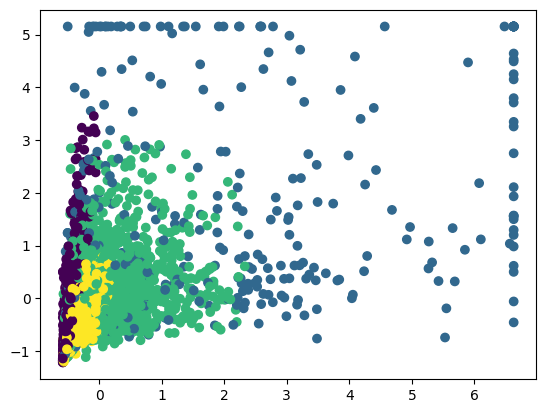

In [43]:
plt.scatter(x=cust_gm['TotalQuantity'], y=cust_gm['AvrgOrderValue'], c=cust_gm['gm_4'])
plt.show()

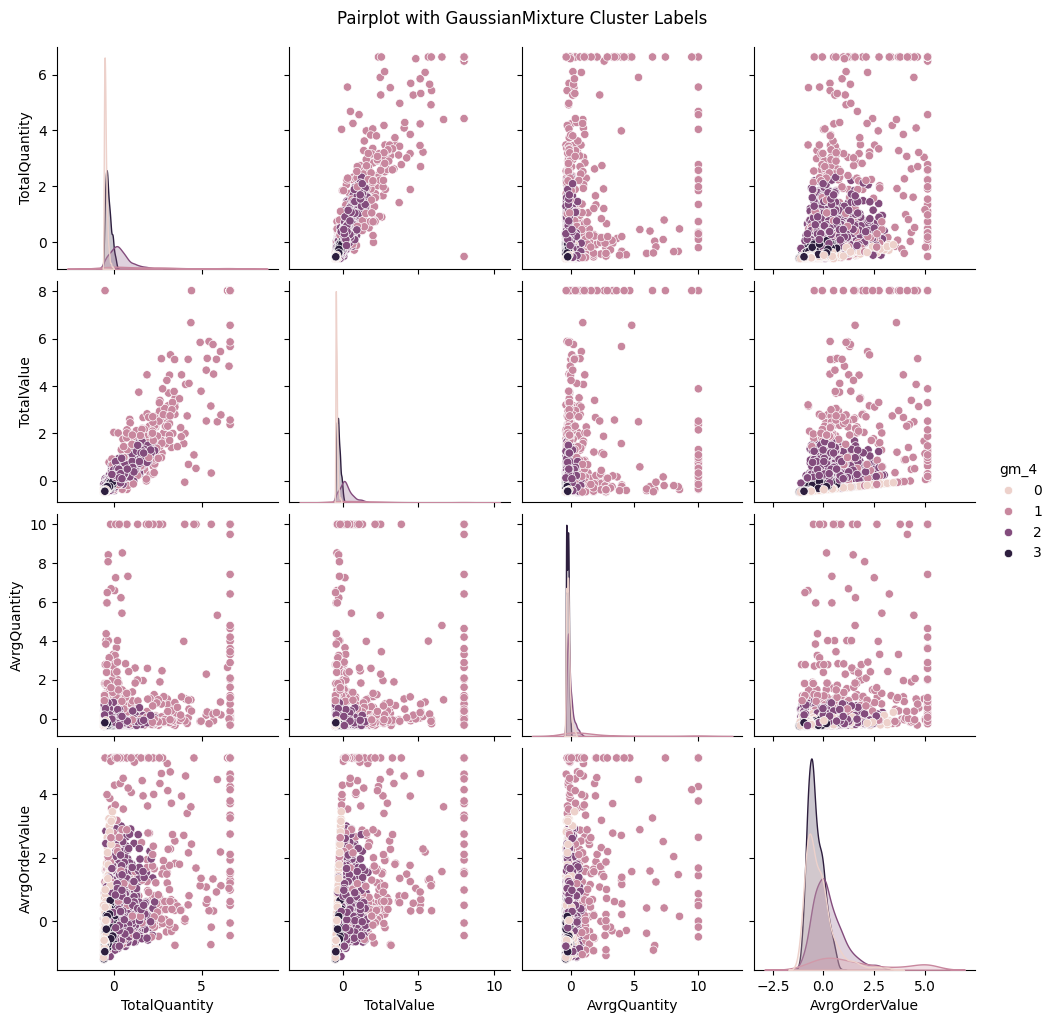

In [44]:
sns.pairplot(cust_gm, hue='gm_4')
plt.suptitle("Pairplot with GaussianMixture Cluster Labels", y=1.02)
plt.savefig("../images/pairplot_gm.png")
plt.show()